In [68]:
import time
import copy
import sys
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
import numpy as np

In [70]:
# Using CIFAR-10 again as in Assignment 1
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# data_dir = '/home/jovyan/harvard-heavy/xin/cifar10_data/'
data_dir = '/n/holyscratch01/kung_lab/xin/cifar_data'
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                         num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [71]:
# Using same ConvNet as in Assignment 1
'''
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)
'''

class ConvNet(nn.Module):
    '''
    From https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [72]:
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

In [73]:
## for test
test_corr = DatasetSplit(testset, [1,2,3])
len(test_corr)

3

In [74]:
def train(epoch, device):
    net.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.cuda(), targets.cuda()
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        
        if isinstance(device['criterion'], nn.CrossEntropyLoss):
            loss = device['criterion'](outputs, targets)
        else:
            loss, data_loss, fisher_loss = device['criterion'](outputs, targets)
            device['train_data_loss_tracker'].append(data_loss.item())
            device['train_fisher_loss_tracker'].append(fisher_loss.item())
            
        loss.backward()
        # nn.utils.clip_grad_norm_(device['net'].parameters(), max_norm = 1)
        nn.utils.clip_grad_value_(device['net'].parameters(), clip_value=1)
        
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        avg_loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        
    sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {avg_loss:.3f} | Train Acc: {acc:.3f}')
    sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device):
    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = device['net'](inputs)
            
            if isinstance(device['criterion'], nn.CrossEntropyLoss):
                loss = device['criterion'](outputs, targets)
            else:
                loss, data_loss, fisher_loss = device['criterion'](outputs, targets)
            
            test_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            avg_loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
            
    device['test_loss_tracker'].append(avg_loss)
    sys.stdout.write(f' | Test Loss: {avg_loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)
    return acc

In [75]:
def create_device(net, device_id, trainset, data_idxs, criterion, lr=0.01,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9,
                                weight_decay=5e-4)
#     optimizer = torch.optim.Adam(device_net.parameters(), lr=lr,
#                                 weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     num_workers=2)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'criterion': criterion,
        'train_loss_tracker': [],
        'train_data_loss_tracker': [],
        'train_fisher_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_data_loss_tracker': [],
        'test_fisher_loss_tracker': [],
        'test_acc_tracker': [],
        }
    
def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentage of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''

    # total number of samples in the dataset
    total_samples = len(dataset)

    # Part 1.1: Implement!
    device_samples = round(data_pct * total_samples)
    return {i: torch.randperm(total_samples)[:device_samples].tolist() 
            for i in range(num_devices)}

def noniid_sampler(dataset, num_users, num_shards_per_user=2):
    """
    Sample non-I.I.D client data from dataset
    """
    total_num_imgs = len(dataset)
    num_shards = int(num_shards_per_user*num_users)
    num_imgs = int(total_num_imgs/num_shards)

    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = np.array(dataset.targets)

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    # idxs_labels[1, :].argsort(): sort idxs by classes
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()].astype(int)
    # idxs_labels:
    # array([[30207,  5662, 55366, ..., 23285, 15728, 11924],
    #        [    0,     0,     0, ...,     9,     9,     9]])
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, num_shards_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0).astype(int)
    return dict_users


In [76]:
def fisher_matrix_diag(device, batch_size=None, empr=False):
    # Init
    model = device['net']
    batch_size = len(device['dataloader'].dataset) if batch_size is None else batch_size
    dataloader =  torch.utils.data.DataLoader(device['dataloader'].dataset,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     num_workers=0)
    fisher={}
    for n,p in model.named_parameters():
        fisher[n]=torch.zeros_like(p.data).detach()
    # Compute
    model.eval()
    total_num_samples = 0
    for image, target in dataloader:
        image, target = image.cuda(), target.cuda()
        total_num_samples += image.size(0)
        # Forward and backward
        model.zero_grad()
        output=model.forward(image)
        if empr:
            target = output.max(1)[1]
        loss=criterion(output, target)
        loss.backward()
        # Get gradients
        for n,p in model.named_parameters():
            if p.grad is not None:
                fisher[n] += image.size(0) * (p.grad.detach() ** 2)
                
    for n in fisher.keys():
        fisher[n] /= total_num_samples
        fisher[n].requires_grad=False
    return fisher

'''
def update_fisher_params(self, current_ds, batch_size, num_batch=None):
    dl = DataLoader(current_ds, batch_size, shuffle=True)
    log_liklihoods = []
    for i, (input, target) in enumerate(dl):
        if num_batch is not None:
            if i > num_batch:
                break
        output = F.log_softmax(self.model(input), dim=1)
        log_liklihoods.append(output[:, target])
    log_likelihood = torch.cat(log_liklihoods).mean()
    grad_log_liklihood = autograd.grad(log_likelihood, self.model.parameters())
    _buff_param_names = [param[0].replace('.', '__') for param in self.model.named_parameters()]
    for _buff_param_name, param in zip(_buff_param_names, grad_log_liklihood):
        self.model.register_buffer(_buff_param_name+'_estimated_fisher', param.data.clone() ** 2)
'''       

def get_fisher_criterion(criterion, fisher, model, model_old, lamb):
    # Regularization for all previous tasks
    def fisher_criterion(output, target):
        loss_reg=0
        for (name,param),(name_old,param_old) in zip(model.named_parameters(), model_old.named_parameters()):
            assert name==name_old
            loss_reg+=torch.sum(fisher[name].detach()*((param_old.detach()-param)**2))
            
        data_loss = criterion(output, target)
            
        print('\n N: %f, R: %f' % (data_loss.item(), lamb*loss_reg.item()))

        return data_loss + lamb*loss_reg, data_loss, loss_reg

    return fisher_criterion

In [77]:
def average_weights(devices):
    '''
    Returns the average of the weights.
    '''
    # Part 1.2: Implement!
    w = [device['net'].state_dict() for device in devices]
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
        
    return w_avg


def zeros_like_copy(in_state_dict):
    out_state_dict = {}
    for key in in_state_dict.keys():
        out_state_dict[key] = torch.zeros_like(in_state_dict[key])
    return out_state_dict
    

def fisher_average_weights(devices):
    w = [device['net'].state_dict() for device in devices]
    fisher = [device['fisher'] for device in devices]
    
    w_avg = zeros_like_copy(w[0])
    w_sum_fisher = zeros_like_copy(w[0])
    
    for key in w_avg.keys():
        for i in range(len(w)):
            try:
                fisher_matrix = fisher[i][key] + 1e-8
                # fisher_matrix = torch.ones_like(w[i][key])
            except:
                fisher_matrix = torch.ones_like(w[i][key])
                
            w_avg[key] += w[i][key]*fisher_matrix
            w_sum_fisher[key] += fisher_matrix
            
        w_avg[key] /= w_sum_fisher[key]
        
    return w_avg
    

def get_devices_for_round(devices, device_pct):
    '''
    '''
    # Part 1.2: Implement!
    num_devices_in_round = round(device_pct*len(devices))
    device_idxs = np.random.permutation(len(devices))[:num_devices_in_round]
    return [devices[i] for i in device_idxs]

In [78]:
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()

# Part 1.3: Implement device creation here
# devices = [create_device(net, i, trainset, data_idxs[i])
#            for i in range(num_devices)]
fisher_batch_size = 1

number_center_devices = 4

center_list = [create_device(net, 50000, trainset, list(range(50000)), criterion)]

# train devices[0]
for i in range(1):
    train(i, center_list[0])
    test(i, center_list[0])
    center_list[0]['scheduler'].step()
    
center_list[0]['fisher'] = fisher_matrix_diag(center_list[0], batch_size=fisher_batch_size)  # TODO: check another way

for i in range(1, number_center_devices):
    center_list.append(copy.deepcopy(center_list[0]))

(Device 50000/Epoch 0) Train Loss: 1.997 | Train Acc: 25.708 | Test Loss: 1.649 | Test Acc: 37.810


In [79]:
# center_device['fisher'].keys()

# center_device['fisher']['fc1.weight']

# plot_all_hist(center_device['fisher'])

In [80]:
a = [1,2,3,4,5,6]
a[3:6]

[4, 5, 6]

In [81]:
rounds = 1
local_epochs = 3
num_devices = 50
device_pct = 0.08
data_pct = 0.02

# data_idxs = iid_sampler(trainset, num_devices, data_pct)
data_idxs = noniid_sampler(trainset, num_devices)


num_device = int(4*5)
fisher_lambda = 5000

round_devices = [create_device(net, i, trainset, data_idxs[i], criterion, lr=0.01)
                       for i in range(num_device)]

number_group = 4
group_size = len(round_devices) // number_group
assert group_size*number_group == len(round_devices)



# center_device: real global, train on global dataset
# --- average_devices ---
# center_list[0]: normal local training, normal average
# center_list[1]: normal local training, fisher average
# center_list[2]: fisher local training, normal average
# center_list[3]: fisher local training, fisher average
# --- round_devices ---
# round_devices[group_size*0 : group_size*1]: center_list[0]
# round_devices[group_size*1 : group_size*2]: center_list[1]
# round_devices[group_size*2 : group_size*3]: center_list[2]
# round_devices[group_size*3 : group_size*4]: center_list[3]




start_time = time.time()
for round_num in range(rounds):
    # Part 1.3: Implement getting devices for each round here
    # round_devices = get_devices_for_round(devices, device_pct)
    print('Round: ', round_num)
    
    # config local devices 
    for group_idx in range(number_group):
        for device in round_devices[group_size*group_idx : group_size*(group_idx+1)]:
            device['net'].load_state_dict(center_list[group_idx]['net'].state_dict())
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            
            if group_idx in [2, 3]:
                device['criterion'] = get_fisher_criterion(
                    criterion= criterion, 
                    fisher   = center_list[group_idx]['fisher'], 
                    model    = device['net'], 
                    model_old= center_list[group_idx]['net'], 
                    lamb     = fisher_lambda)
            else:
                device['criterion'] = criterion

    
    for device_idx, device in enumerate(round_devices):
        # if device_idx<=4:
        #     continue
        # test(-1, device)
        for local_epoch in range(local_epochs):
            train(local_epoch, device) 
            
    # naive average
    w_navg_nreg = average_weights(round_devices[group_size*0 : group_size*1])
    w_navg_freg = average_weights(round_devices[group_size*2 : group_size*3])

    center_list[0]['net'].load_state_dict(w_navg_nreg)
    center_list[2]['net'].load_state_dict(w_navg_freg)
    
    
    
    # compute fisher and fisher average
    for device in round_devices:
        device['criterion'] = criterion
        device['fisher'] = fisher_matrix_diag(device, batch_size=fisher_batch_size)

    w_favg_nreg = fisher_average_weights(round_devices[group_size*1 : group_size*2])
    w_favg_freg = fisher_average_weights(round_devices[group_size*3 : group_size*4])

    center_list[1]['net'].load_state_dict(w_favg_nreg)
    center_list[3]['net'].load_state_dict(w_favg_freg)

    
    # record in 'test_acc_tracker'
    print('\n' + 'v-'*10 + '  Round %d Center Test  ' % round_num + '-v'*10 )
    for i in range(len(center_list)):
        test(round_num, center_list[i])
    print('^-'*10 + '  Round %d Center Test  ' % round_num + '-^'*10 )

    print('\n' + 'v-'*10 + '  Round %d Local Test  ' % round_num + '-v'*10 )
    for i in range(len(round_devices)):
        test(round_num, round_devices[i])
    print('^-'*10 + '  Round %d Local Test  ' % round_num + '-^'*10 )

    # for i in [2, 3]:
    #    center_list[i]['fisher'] = fisher_matrix_diag(center_list[i], batch_size=fisher_batch_size)  # TODO: check another way


Round:  0
(Device 9/Epoch 2) Train Loss: 0.714 | Train Acc: 50.400
 N: 1.863191, R: 0.000000

 N: 1.415530, R: 2.197925

 N: 1.836533, R: 19.028697

 N: 1.381077, R: 15.253950

 N: 1.158243, R: 23.672660

 N: 1.182920, R: 35.797602

 N: 1.743668, R: 23.544312

 N: 1.656102, R: 34.780486
(Device 10/Epoch 0) Train Loss: 20.814 | Train Acc: 40.300
 N: 1.529636, R: 74.794022

 N: 1.385528, R: 76.028234

 N: 1.414825, R: 44.883387

 N: 1.195718, R: 62.013827

 N: 1.167155, R: 111.861425

 N: 1.244386, R: 130.454358

 N: 1.413587, R: 100.507755

 N: 1.416406, R: 73.273638
(Device 10/Epoch 1) Train Loss: 85.573 | Train Acc: 46.000
 N: 1.457048, R: 88.306861

 N: 1.347608, R: 110.739563

 N: 1.308983, R: 111.771422

 N: 1.201043, R: 103.141246

 N: 1.263709, R: 92.968214

 N: 1.125350, R: 87.230531

 N: 1.165344, R: 92.996201

 N: 1.190898, R: 102.697881
(Device 10/Epoch 2) Train Loss: 99.989 | Train Acc: 47.600
 N: 1.942323, R: 0.000000

 N: 1.444634, R: 1.991405

 N: 2.271544, R: 20.096768



In [82]:
list(round_devices[0].keys())

['net',
 'id',
 'dataloader',
 'optimizer',
 'scheduler',
 'criterion',
 'train_loss_tracker',
 'train_data_loss_tracker',
 'train_fisher_loss_tracker',
 'train_acc_tracker',
 'test_loss_tracker',
 'test_data_loss_tracker',
 'test_fisher_loss_tracker',
 'test_acc_tracker',
 'fisher']

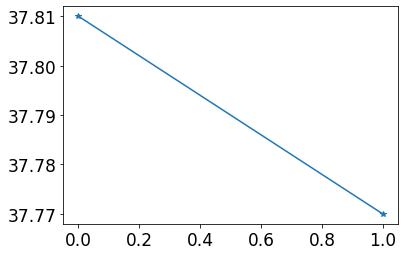

In [83]:
plt.plot(center_list[2]['test_acc_tracker'], '*-')

In [84]:
def plot_all_hist(state_dict, ax, title):
    big_tensor = []
    for key in state_dict.keys():
        big_tensor.append(state_dict[key].flatten())
    big_tensor = torch.cat(big_tensor)

    # sns.distplot(np.log(abs(big_tensor.cpu().numpy())+1e-12), ax=ax)
    ax.hist(np.log10(abs(big_tensor.cpu().numpy())+1e-8), bins=100)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.set_title(title)
    # ax.set_xlabel('log(F_i)')

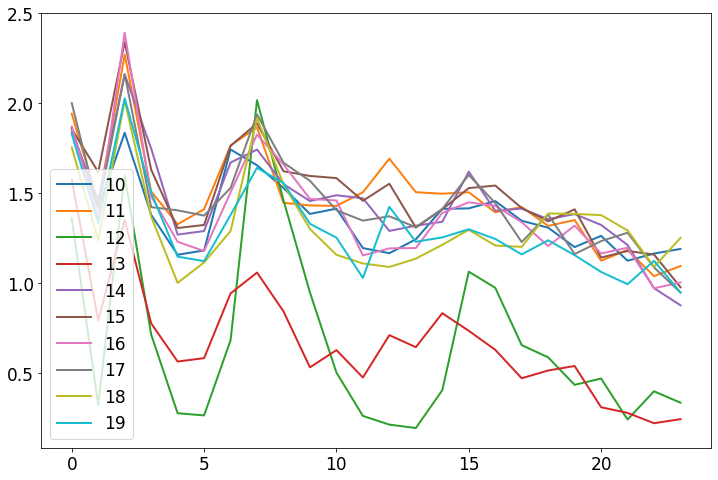

In [85]:
plt.figure(figsize=[12,8])
for i in range(10, 20):
    plt.plot(round_devices[i]['train_data_loss_tracker'], label=str(i), linewidth=2)
plt.legend()

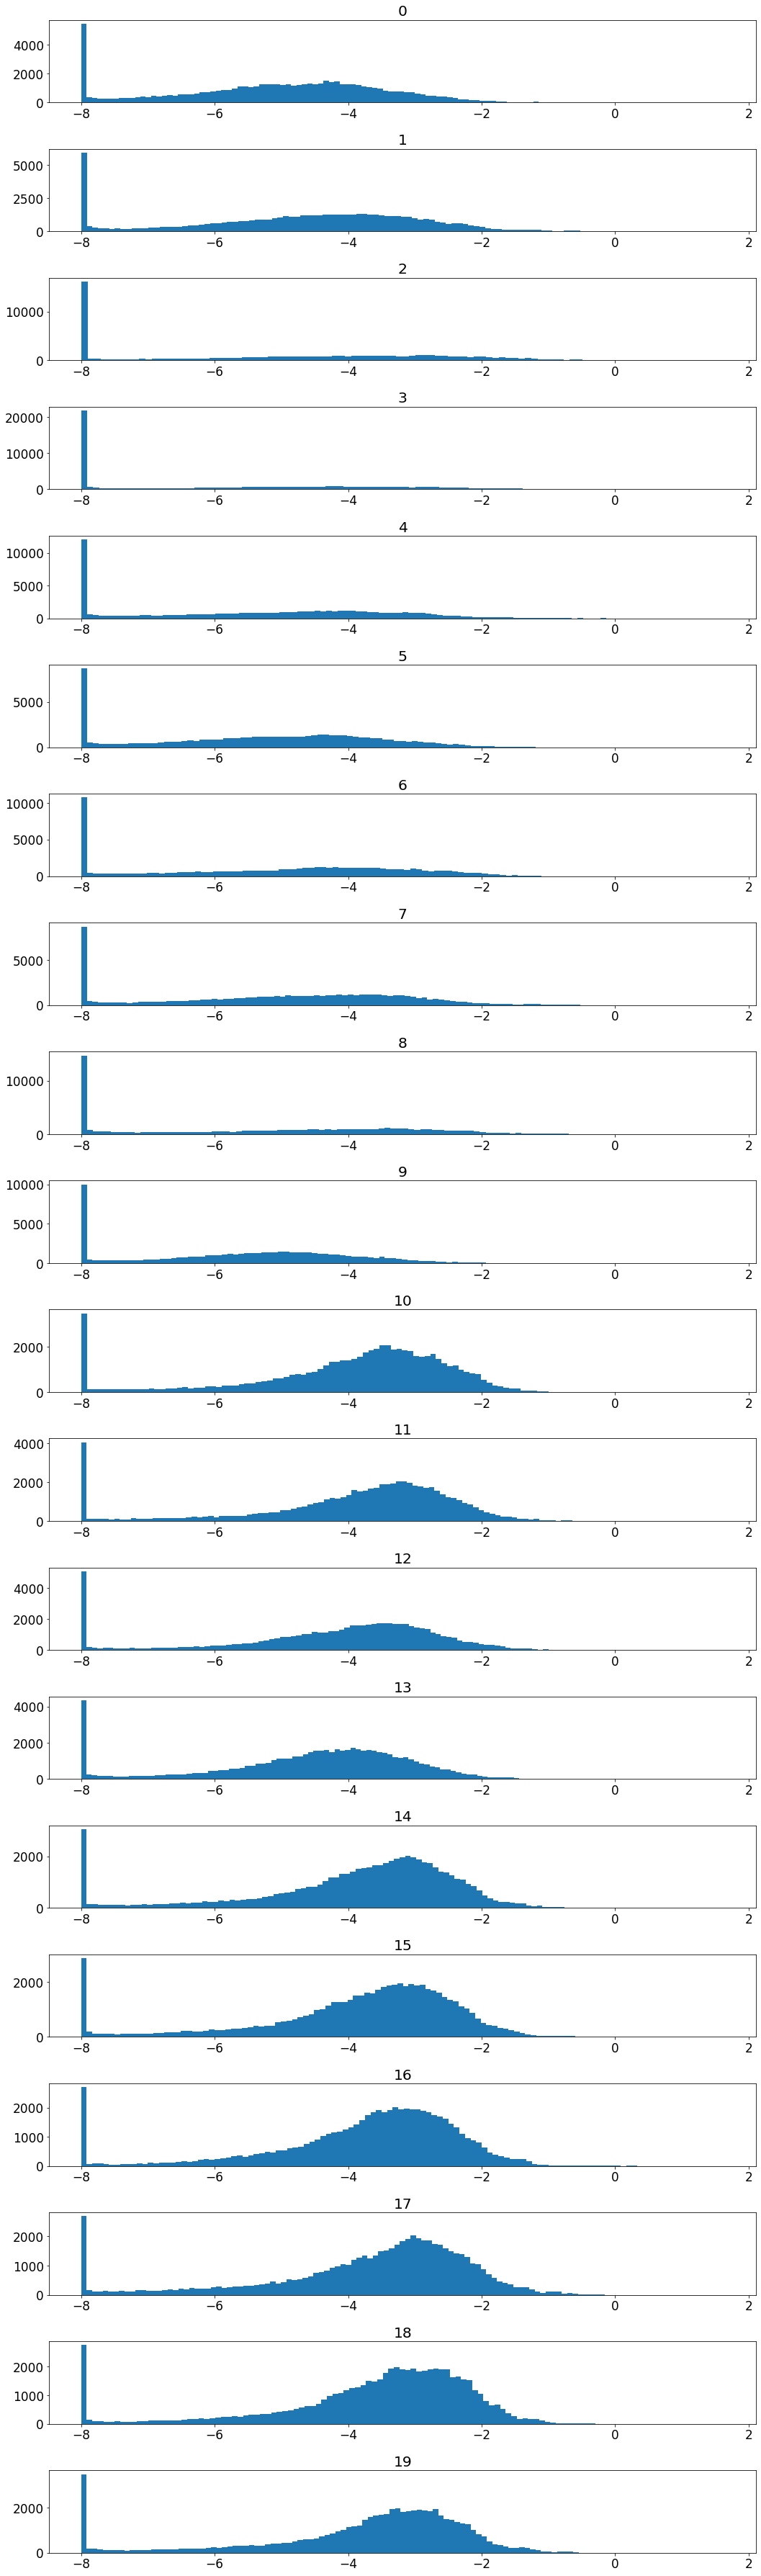

In [86]:
fig, ax = plt.subplots(len(round_devices), 1,  figsize=(15,50), sharex=True)
for i in range(len(round_devices)):
    plot_all_hist(round_devices[i]['fisher'], ax[i], str(i))
plt.tight_layout()

TypeError: plot_all_hist() missing 1 required positional argument: 'title'

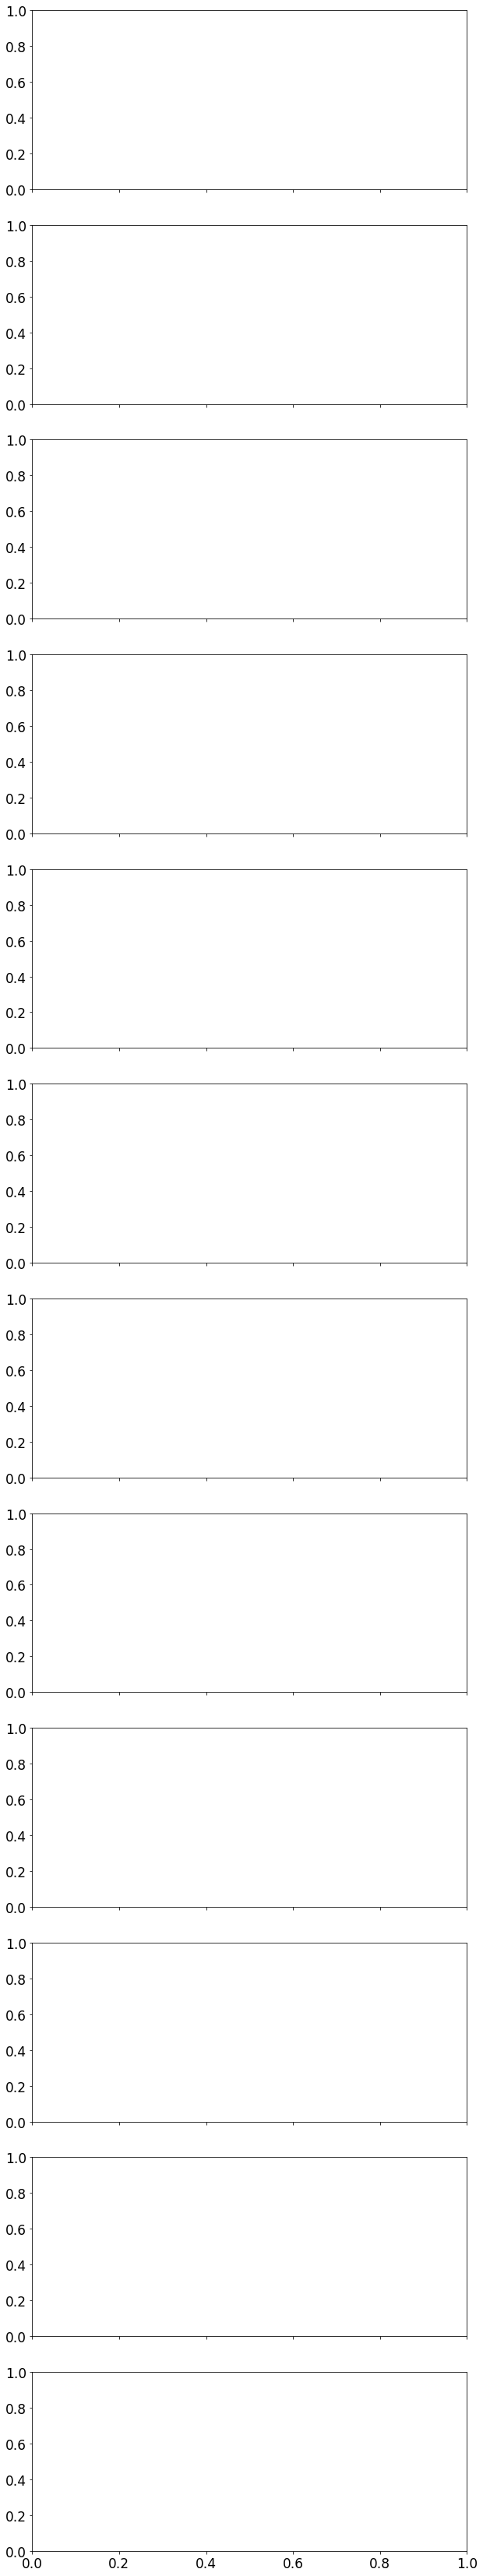

In [87]:
fig, ax = plt.subplots(12, 1,  figsize=(10,60), sharex=True)
for i in range(0, 12):
    plot_all_hist(round_devices[i]['fisher'], ax[i])

In [ ]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[24,8])
# for i in [6,7,8,9,10,11]:
#     p = ax1.plot(devices[i]['train_acc_tracker'], label='w/ fisher reg' if i <=8 else 'w/o fisher reg', linewidth=3, linestyle='dashed' if i<=8 else 'solid')
#     ax2.plot([devices[i]['test_acc_tracker'][-1]]*len(devices[i]['train_acc_tracker']), label='w/ fisher reg' if i <=8 else 'w/o fisher reg', color=p[0].get_color(), linewidth=3, linestyle='dashed' if i<=8 else 'solid')
    
# ax1.plot([center_device['test_acc_tracker'][-1]]*len(devices[i]['train_acc_tracker']),'v', label='start from')
# ax1.legend()
# ax2.legend()

In [ ]:
# import jovian
# jovian.commit(filename='lab-tworound.ipynb', message='ID:3 version 2')